## 计算位置 tx，归一化飞行时间 ntof 和 中子能量 ce

### 准备


In [1]:
TFile *ipf = new TFile("AddVeto.root");
TTree *tree = (TTree*)ipf->Get("tree");

TFile *opf = new TFile("TOFNorm.root", "recreate");
TTree *opt = new TTree("tree", "tx ntof ce");
tree->AddFriend(opt);

Int_t itu, itd;
tree->SetBranchAddress("itu", &itu);
tree->SetBranchAddress("itd", &itd);

Long64_t nentries = tree->GetEntries();

Double_t tx, ntof, ce;

opt->Branch("tx", &tx, "tx/D");

opt->SetAlias("tLimit", "itu < 4095 && itd < 4095 && itu >= 0 && itd >= 0");
opt->SetAlias("vtLimit", "vitu < 4095 && vitd < 4095 && vitu >= 0 && vitd >= 0");

TCanvas *c1 = new TCanvas;

### 计算 tx

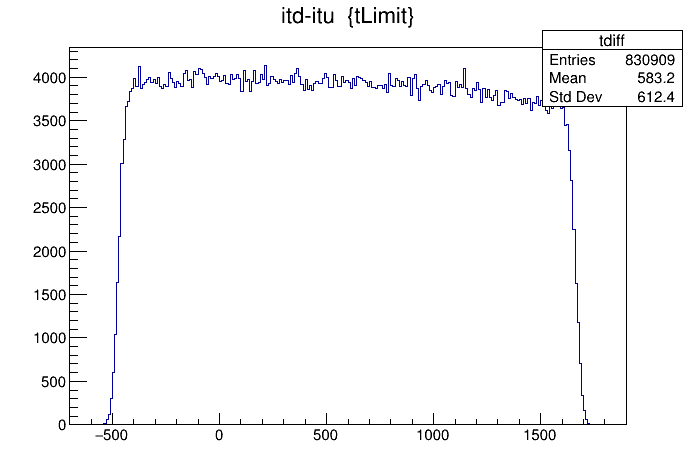

In [2]:
tree->Draw("itd-itu >> tdiff(260, -700, 1900)", "tLimit");
c1->Draw();

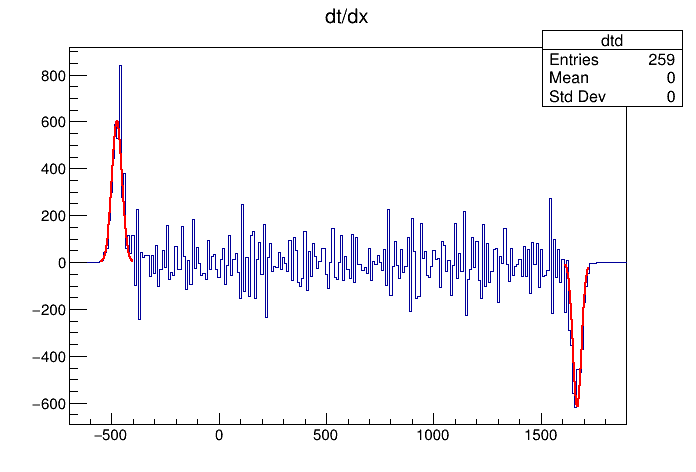

 FCN=441.705 FROM MIGRAD    STATUS=CONVERGED      77 CALLS          78 TOTAL
                     EDM=9.13534e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     6.03402e+02   1.32550e+01   1.04064e-01   6.97900e-06
   2  Mean        -4.72488e+02   3.96158e-01   4.06498e-03  -2.12489e-04
   3  Sigma        2.34747e+01   3.35141e-01   3.49318e-05   3.20266e-02
 FCN=704.537 FROM MIGRAD    STATUS=CONVERGED     105 CALLS         106 TOTAL
                     EDM=8.34014e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -6.15705e+02   1.36300e+01  -9.82345e-03  -9.57554e-06
   2  Mean         1.66847e+03   4.48577e-01  -7.89486e-04  -9.17259e-04
   3  Sigma        1

In [3]:
TH1D *tdiff = (TH1D*)gDirectory->Get("tdiff");
TH1D *dtd = new TH1D("dtd", "dt/dx", 259, -695, 1895);
Double_t lastBin = tdiff->GetBinContent(1);
for (int i = 2; i <= tdiff->GetNbinsX(); ++i) {
    Double_t bin = tdiff->GetBinContent(i);
    dtd->Fill(tdiff->GetBinLowEdge(i), bin-lastBin);
    lastBin = bin;
}
dtd->Sumw2(0);
dtd->Draw();
TF1 *f1 = new TF1("f1", "gaus", -550, -400);
TF1 *f2 = new TF1("f2", "gaus", 1610, 1720);
f1->SetParameters(700, -460, 20);
f2->SetParameters(-600, 1650, 20);
dtd->Fit(f1, "RN", "");
dtd->Fit(f2, "R", "");
f1->Draw("same");
c1->Draw();

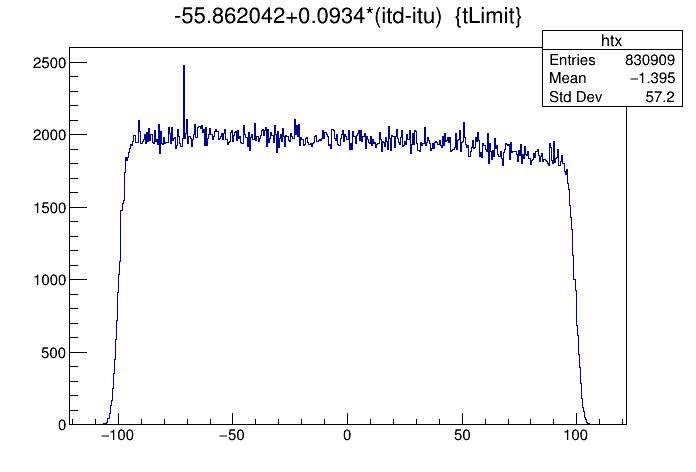

In [4]:
// calibration
Double_t txl = f1->GetParameter(1);
Double_t txr = f2->GetParameter(1);
// tx = 200.0 / (txr - txl) * ((td-tu)-txl) - 100.0
Double_t tp0 = 200.0 * txl / (txl-txr) - 100.0;
Double_t tp1 = 200.0 / (txr-txl);
// cout << tp0 << "    " << tp1 << endl;
TString stp0(Form("%lf", tp0));
TString stp1(Form("%.4lf", tp1));
// cout << tp0 + tp1 * -700 << "  " << tp0 + tp1 * 1900 << endl;
tree->Draw(stp0+"+"+stp1+"*(itd-itu) >> htx(520, -121.25, 121.629)", "tLimit");
delete f1, f2;
c1->Draw();

In [5]:
for (Long64_t jentry = 0; jentry != nentries; ++jentry) {
    tree->GetEntry(jentry);
    tx = tp0 + tp1 * (itd - itu);
    opt->Fill();
}

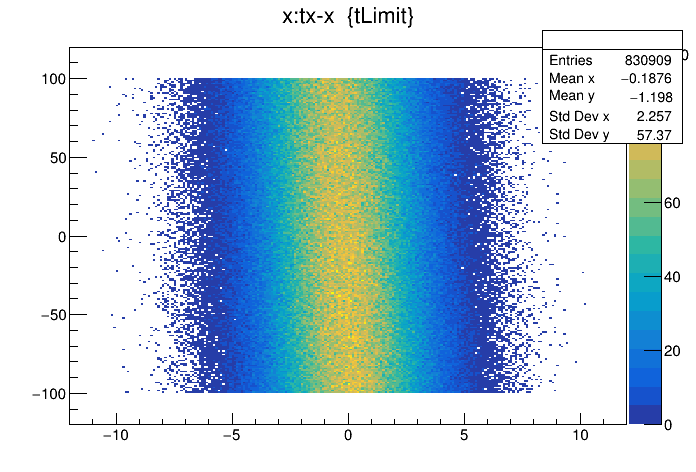

In [6]:
tree->Draw("x:tx-x >> (240, -12, 12, 240, -120, 120)", "tLimit", "colz");
c1->Draw();

### 计算ntof

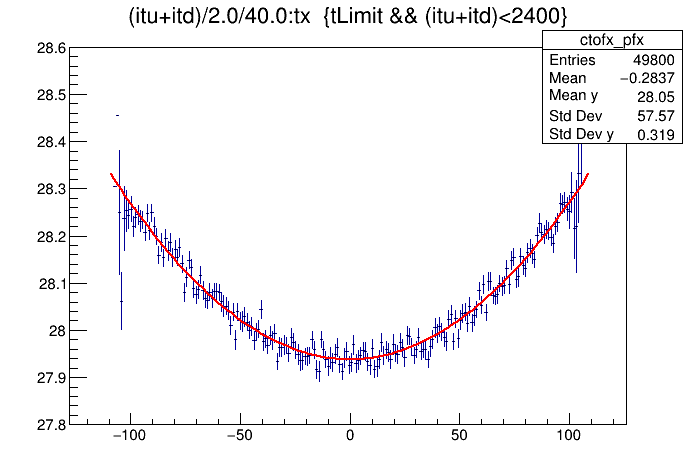

 FCN=219.237 FROM MIGRAD    STATUS=CONVERGED      46 CALLS          47 TOTAL
                     EDM=7.75146e-13    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  TOF_fix     -1.10565e+01   2.33335e-01   9.79166e-06   4.05937e-06
   2  ntof         3.35949e+00   4.61305e-02   1.93581e-06   6.45814e-06


In [7]:
// profile and fit
tree->Draw("(itu+itd)/2.0/40.0:tx >> ctofx", "tLimit && (itu+itd)<2400", "goff");
TH2D *ctofx = (TH2D*)gDirectory->Get("ctofx");
TProfile *ctofxpx = ctofx->ProfileX();
ctofxpx->GetYaxis()->SetRangeUser(27.8, 28.6);
ctofxpx->Draw();
f1 = new TF1("f1", "-[0]+[1]*sqrt(x*x+502.5*502.5)/100.0", -110, 110);
f1->SetParName(0, "TOF_fix");
f1->SetParName(1, "ntof");
ctofxpx->Fit(f1, "R");
Double_t tofFix = f1->GetParameter(0);
delete f1;
c1->Draw();

### 填入 ntof 和 ce

In [8]:
TBranch *ntofBranch = opt->Branch("ntof", &ntof, "ntof/D");
TBranch *ceBranch = opt->Branch("ce", &ce, "ce/D");

for (Long64_t jentry = 0; jentry != nentries; ++jentry) {
    tree->GetEntry(jentry);
    // ntof
    Double_t ctof = (itu + itd) / 80.0;
    ntof = (ctof + tofFix) * 100.0 / sqrt(502.5*502.5 + tx*tx);
    // ce
    if (ntof > 5) {
        ce = 72.29824 * 72.29824 / ntof / ntof;
    } else {
        ce = 0.0;
    }
    ntofBranch->Fill();
    ceBranch->Fill();
}

In [9]:
opt->Print();

opt->Write();
opf->Close();

******************************************************************************
*Tree    :tree      : tx ntof ce                                             *
*Entries :  1000000 : Total =        24072127 bytes  File  Size =   17946970 *
*        :          : Tree compression factor =   1.34                       *
******************************************************************************
*Br    0 :tx        : tx/D                                                   *
*Entries :  1000000 : Total  Size=    8023705 bytes  File Size  =    4675118 *
*Baskets :      250 : Basket Size=      32000 bytes  Compression=   1.71     *
*............................................................................*
*Br    1 :ntof      : ntof/D                                                 *
*Entries :  1000000 : Total  Size=    8024217 bytes  File Size  =    6767740 *
*Baskets :      250 : Basket Size=      32000 bytes  Compression=   1.18     *
*...................................................

<div>
    <span style="float:left"><a href="hw1_2_2.ipynb">prev</a></span>
    <span style="float:right"><a href="hw1_2_4.ipynb">next</a></span>
</div>